In [190]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
import datetime

import cv2

# Data preparation

In [191]:
column_names = ['event_timestamp','event_structure_version','event_type','game_clock','play_clock','stop_flag','tag_serial_number','player_id','X','Y','Z','distance','Vx','Vy','V','Ax','Ay','A','direction']
df = pd.read_csv('sample5s.csv',names=column_names)

In [192]:
df.head()

,event_timestamp,event_structure_version,event_type,game_clock,play_clock,stop_flag,tag_serial_number,player_id,X,Y,Z,distance,Vx,Vy,V,Ax,Ay,A,direction
0,1652558856725,4,player,NaN,NaN,1,20150,136529.0,33038,-17436,933.0,2.1850,-0.11,-0.02,0.21,-0.00,-0.00,0.00,-167.91
1,1652558857910,4,player,NaN,NaN,1,20285,136531.0,-4856,-9452,1693.0,2.3466,-0.66,-2.34,2.51,-0.00,0.00,0.01,-105.78
2,1652558857168,4,player,NaN,NaN,1,20195,136543.0,32901,17404,1232.0,3.2877,-0.20,0.18,0.29,-0.00,0.00,0.00,136.81
3,1652558859897,4,player,NaN,NaN,1,20262,138136.0,-27617,-6218,805.0,2.7404,0.08,-0.09,0.67,-0.01,-0.00,0.01,-49.18
4,1652558855809,4,player,NaN,NaN,1,20127,136514.0,-2204,2092,1739.0,2.4634,-4.79,2.31,5.43,0.00,0.01,0.01,154.26


In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10583 entries, 0 to 10582
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   event_timestamp          10583 non-null  int64  
 1   event_structure_version  10583 non-null  int64  
 2   event_type               10583 non-null  object 
 3   game_clock               0 non-null      float64
 4   play_clock               0 non-null      float64
 5   stop_flag                10583 non-null  int64  
 6   tag_serial_number        10583 non-null  int64  
 7   player_id                9983 non-null   float64
 8   X                        10583 non-null  int64  
 9   Y                        10583 non-null  int64  
 10  Z                        10583 non-null  float64
 11  distance                 10583 non-null  float64
 12  Vx                       10583 non-null  float64
 13  Vy                       10583 non-null  float64
 14  V                     

## Player

In [194]:
player = df[df['event_type'] == 'player']

In [195]:
# extract the relevent columns
player = player[['event_timestamp','tag_serial_number','player_id','X','Y']]
player.head()

,event_timestamp,tag_serial_number,player_id,X,Y
0,1652558856725,20150,136529.0,33038,-17436
1,1652558857910,20285,136531.0,-4856,-9452
2,1652558857168,20195,136543.0,32901,17404
3,1652558859897,20262,138136.0,-27617,-6218
4,1652558855809,20127,136514.0,-2204,2092


In [196]:
player.describe()

,event_timestamp,tag_serial_number,player_id,X,Y
count,7.783000e+03,7783.000000,7183.000000,7783.000000,7783.000000
mean,1.652559e+12,20223.690222,136735.574551,-2122.553900,-2169.110240
std,1.446454e+03,94.374246,451.205326,25849.854572,11374.061105
min,1.652559e+12,20033.000000,136503.000000,-35102.000000,-20425.000000
25%,1.652559e+12,20150.000000,136529.000000,-27728.500000,-10436.500000
50%,1.652559e+12,20229.000000,136558.000000,-4445.000000,-3264.000000
75%,1.652559e+12,20313.000000,136585.000000,27220.000000,4693.000000
max,1.652559e+12,20364.000000,138138.000000,35684.000000,30603.000000


Explore missing data

In [197]:
# missing data: 600 records have no 'player_id', but (X,Y) is complete
player.isnull().sum()

event_timestamp        0
tag_serial_number      0
player_id            600
X                      0
Y                      0
dtype: int64

In [198]:
player[['player_id','tag_serial_number']].nunique()

player_id            73
tag_serial_number    79
dtype: int64

In [199]:
# records that have missing 'player_id' come from 6 sensors
player[player['player_id'].isnull()]['tag_serial_number'].unique()

array([20353, 20277, 20243, 20339, 20363, 20326], dtype=int64)

In [200]:
# use one sensor as an example to explore the data, same procedure was repeated for other 5 sensors
# each sensor has 100 records
sensor_id = 20353
player[player['tag_serial_number'] == sensor_id].sort_values('event_timestamp').count()

event_timestamp      100
tag_serial_number    100
player_id              0
X                    100
Y                    100
dtype: int64

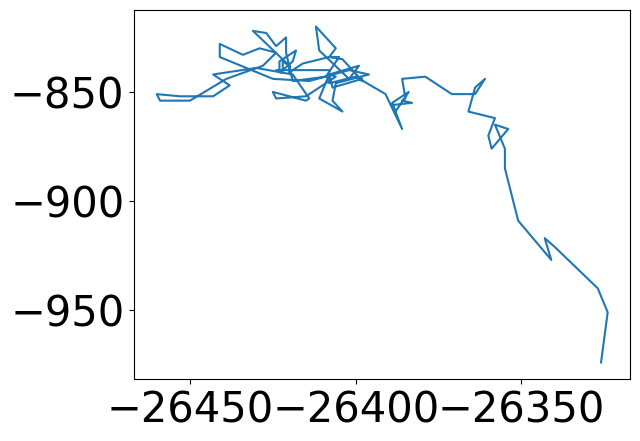

In [201]:
# plots the (X,Y) for each sonsor in a consequtive of 5s
x_ = player[player['tag_serial_number'] == sensor_id].sort_values('event_timestamp')['X']
y_ = player[player['tag_serial_number'] == sensor_id].sort_values('event_timestamp')['Y']
plt.plot(x_,y_)

Two methods to deal will the missing data:
Method 1: drop nan values, 8% player missing in the field.
Method 2: resonably assuming that each each player_id has a unique tag_serial_number, therefore 600 missing data belongs to 6 unique players monitored by 6 unique sensors. Assign random values to player_id. 
In this analysis, Method 2 is applied.

In [202]:
def fill_in_id (sensor_id_missing):
    if sensor_id_missing == 20353:
        player_id_missing = 1;
    elif  sensor_id_missing == 20277:
        player_id_missing = 2;
    elif  sensor_id_missing == 20243:
        player_id_missing = 3;
    elif  sensor_id_missing == 20339:
        player_id_missing = 4;
    elif  sensor_id_missing == 20363:
        player_id_missing = 5;
    else:
        player_id_missing = 6;
    return player_id_missing

In [203]:
player.loc[player['player_id'].isnull(),'player_id'] = player.loc[df['player_id'].isnull(),'tag_serial_number'].apply(lambda x:fill_in_id(x))

In [204]:
player.isnull().sum()

event_timestamp      0
tag_serial_number    0
player_id            0
X                    0
Y                    0
dtype: int64

## Ball

In [205]:
ball = df[df['event_type'] == 'ball']

In [206]:
# fix the column indexs of ball
ball_columns_name = ['event_timestamp','event_structure_version','event_type','game_clock','play_clock','stop_flag','tag_serial_number','X','Y','Z','distance','Vx','Vy','V','Ax','Ay','A','direction']
ball = ball.drop(ball.columns[-1],axis=1)
ball = ball.set_axis(ball_columns_name,axis=1)

In [207]:
# delete the irrelevent columns in ball
ball = ball[['event_timestamp','tag_serial_number','X','Y']]
# add a column in ball named 'player_id' with assigned values of 0 so that ball and player have the same size
ball['player_id'] = 0

In [208]:
# adjust the sequence of column index of ball
ball = ball[['event_timestamp','tag_serial_number', 'player_id', 'X', 'Y']]
ball.head()

,event_timestamp,tag_serial_number,player_id,X,Y
5,1652558859721,2147582624,0,-26243.0,-14777
9,1652558859654,2147578827,0,-27035.0,3368
10,1652558856653,2147585778,0,-26260.0,-14604
18,1652558855704,2147567164,0,26456.0,-4011
19,1652558855080,2147567164,0,26429.0,-3935


Explore the data

In [209]:
# missing data: no
ball.isnull().sum()

event_timestamp      0
tag_serial_number    0
player_id            0
X                    0
Y                    0
dtype: int64

In [210]:
# unique numbers: data of ball comes from 14 unique sensors
ball['tag_serial_number'].nunique()

14

## Combine player and ball into one dataframe

In [221]:
new_df = pd.concat([player,ball],axis=0)
new_df.head()

,event_timestamp,tag_serial_number,player_id,X,Y
0,1652558856725,20150,136529.0,33038.0,-17436
1,1652558857910,20285,136531.0,-4856.0,-9452
2,1652558857168,20195,136543.0,32901.0,17404
3,1652558859897,20262,138136.0,-27617.0,-6218
4,1652558855809,20127,136514.0,-2204.0,2092


# Aggregate to 50 ms

In [222]:
# resample to 50ms
new_df['timestamp_resample'] = new_df.iloc[:,0]//50*50
new_df.head()

,event_timestamp,tag_serial_number,player_id,X,Y,timestamp_resample
0,1652558856725,20150,136529.0,33038.0,-17436,1652558856700
1,1652558857910,20285,136531.0,-4856.0,-9452,1652558857900
2,1652558857168,20195,136543.0,32901.0,17404,1652558857150
3,1652558859897,20262,138136.0,-27617.0,-6218,1652558859850
4,1652558855809,20127,136514.0,-2204.0,2092,1652558855800


In [223]:
# for each unique tag_serial_number, aggregate-mean
x_ave = new_df.groupby(['tag_serial_number','timestamp_resample']).mean()['X']
y_ave = new_df.groupby(['tag_serial_number','timestamp_resample']).mean()['Y']

In [224]:
new_df['X_ave'] = new_df.apply(lambda x:x_ave[x['tag_serial_number'],x['timestamp_resample']],axis=1)
new_df['Y_ave'] = new_df.apply(lambda x:y_ave[x['tag_serial_number'],x['timestamp_resample']],axis=1)
new_df.head()

,event_timestamp,tag_serial_number,player_id,X,Y,timestamp_resample,X_ave,Y_ave
0,1652558856725,20150,136529.0,33038.0,-17436,1652558856700,33038.0,-17436.0
1,1652558857910,20285,136531.0,-4856.0,-9452,1652558857900,-4856.0,-9452.0
2,1652558857168,20195,136543.0,32901.0,17404,1652558857150,32901.0,17404.0
3,1652558859897,20262,138136.0,-27617.0,-6218,1652558859850,-27617.0,-6218.0
4,1652558855809,20127,136514.0,-2204.0,2092,1652558855800,-2204.0,2092.0


In [225]:
# eliminate the data that are outside of the field
x_top = 24231.6
x_bot = -24231.6
y_r = 54864.0
y_l = -54864.0
new_df = new_df[(new_df['X_ave'] <= x_top) & (new_df['X_ave'] >= x_bot) & (new_df['Y_ave'] <= y_r) & (new_df['Y_ave'] >= y_l)]
new_df.describe()

,event_timestamp,tag_serial_number,player_id,X,Y,timestamp_resample,X_ave,Y_ave
count,2.539000e+03,2.539000e+03,2539.000000,2539.000000,2539.000000,2.539000e+03,2539.000000,2539.000000
mean,1.652559e+12,1.691861e+08,115069.924380,-2679.099646,-451.801497,1.652559e+12,-2679.099646,-451.801497
std,1.442287e+03,5.786266e+08,49769.793026,8799.126435,8268.625619,1.442336e+03,8799.115950,8268.613161
min,1.652559e+12,2.003300e+04,0.000000,-24197.000000,-15968.000000,1.652559e+12,-24197.000000,-15968.000000
25%,1.652559e+12,2.016200e+04,136514.000000,-7221.000000,-6102.000000,1.652559e+12,-7221.000000,-6080.500000
50%,1.652559e+12,2.021900e+04,136544.000000,-3444.000000,-1227.000000,1.652559e+12,-3444.000000,-1220.500000
75%,1.652559e+12,2.033400e+04,136580.000000,1443.500000,4484.000000,1.652559e+12,1443.500000,4484.000000
max,1.652559e+12,2.147581e+09,137385.000000,20572.000000,20157.000000,1.652559e+12,20572.000000,20157.000000


# Plotting

In [229]:
df_image = new_df
# convert timestamp format
df_image['datetime'] = pd.to_datetime(df_image['event_timestamp'],utc=True,unit='ms',origin='unix')
df_image['datetime_resample'] = pd.to_datetime(df_image['timestamp_resample'],utc=True,unit='ms',origin='unix')
df_image.head()

,event_timestamp,tag_serial_number,player_id,X,Y,timestamp_resample,X_ave,Y_ave,datetime,datetime_resample
1,1652558857910,20285,136531.0,-4856.0,-9452,1652558857900,-4856.0,-9452.0,2022-05-14 20:07:37.910000+00:00,2022-05-14 20:07:37.900000+00:00
4,1652558855809,20127,136514.0,-2204.0,2092,1652558855800,-2204.0,2092.0,2022-05-14 20:07:35.809000+00:00,2022-05-14 20:07:35.800000+00:00
7,1652558858395,20334,136586.0,-15350.0,1492,1652558858350,-15350.0,1492.0,2022-05-14 20:07:38.395000+00:00,2022-05-14 20:07:38.350000+00:00
29,1652558856376,20297,136583.0,-67.0,-4808,1652558856350,-67.0,-4808.0,2022-05-14 20:07:36.376000+00:00,2022-05-14 20:07:36.350000+00:00
34,1652558858673,20219,136560.0,20536.0,13121,1652558858650,20536.0,13121.0,2022-05-14 20:07:38.673000+00:00,2022-05-14 20:07:38.650000+00:00


In [230]:
df_image.groupby('datetime_resample')

In [182]:
unique_timestamp = df_image.sort_values('timestamp_resample')['datetime_resample'].unique()
#unique_timestamp.strftime('%Y-%m-%d %H:%M:%S.%f')[:-4]
unique_timestamp

<DatetimeArray>
[       '2022-05-14 20:07:35+00:00', '2022-05-14 20:07:35.050000+00:00',
 '2022-05-14 20:07:35.100000+00:00', '2022-05-14 20:07:35.150000+00:00',
 '2022-05-14 20:07:35.200000+00:00', '2022-05-14 20:07:35.250000+00:00',
 '2022-05-14 20:07:35.300000+00:00', '2022-05-14 20:07:35.350000+00:00',
 '2022-05-14 20:07:35.400000+00:00', '2022-05-14 20:07:35.450000+00:00',
 '2022-05-14 20:07:35.500000+00:00', '2022-05-14 20:07:35.550000+00:00',
 '2022-05-14 20:07:35.600000+00:00', '2022-05-14 20:07:35.650000+00:00',
 '2022-05-14 20:07:35.700000+00:00', '2022-05-14 20:07:35.750000+00:00',
 '2022-05-14 20:07:35.800000+00:00', '2022-05-14 20:07:35.850000+00:00',
 '2022-05-14 20:07:35.900000+00:00', '2022-05-14 20:07:35.950000+00:00',
        '2022-05-14 20:07:36+00:00', '2022-05-14 20:07:36.050000+00:00',
 '2022-05-14 20:07:36.100000+00:00', '2022-05-14 20:07:36.150000+00:00',
 '2022-05-14 20:07:36.200000+00:00', '2022-05-14 20:07:36.250000+00:00',
 '2022-05-14 20:07:36.300000+00:00'

In [22]:
# create a new folder for images
os.makedirs('./images', exist_ok=True)

In [183]:
# plotting: blue dots represent players, red dot represents the ball.
plt.rcParams.update({'font.size': 30})
for i in range(len(unique_timestamp)):
    plt.figure(figsize = (19.2,10.8))
    tf = df_image[df_image['datetime_resample'] == unique_timestamp[i]]
    plt.scatter(tf[tf['player_id'] != 0]['Y_ave'],tf[tf['player_id'] != 0]['X_ave'], color='b', marker='o', s = 100)
    plt.scatter(tf[tf['player_id'] == 0]['Y_ave'],tf[tf['player_id'] == 0]['X_ave'], color ='r', marker='o',  s = 100)
    plt.xticks(np.arange(-60000, 60000+20000,step=20000))
    plt.yticks(np.arange(-40000, 30000+10000,step=10000))
    name = tf['datetime'].iloc[0].strftime('%Y-%m-%d %H:%M:%S.%f')[:-4]
    plt.title('UTC ' + name)
    plt.savefig('./images/' + str(i) + '.png')
    plt.clf()

C:\Users\Xiaoyi Chen\AppData\Local\Temp\ipykernel_13216\2209370944.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (19.2,10.8))


<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

<Figure size 1920x1080 with 0 Axes>

In [185]:
video_name = 'usfl_game.avi'

In [186]:
images = ['./images/' + str(i) + '.png' for i in range(len(unique_timestamp))]
frame = cv2.imread(images[0])
height, width, layers = frame.shape
video = cv2.VideoWriter(video_name, 0, 20, (width,height))
for image in images:
    video.write(cv2.imread(image))
cv2.destroyAllWindows()
video.release()